In [1]:
import yaml
config_path = './config/config.yaml'

In [2]:
config = yaml.load(open(config_path))

/opt/conda/envs/pytorch_py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  if __name__ == '__main__':


## dataset和dataloader 定义

In [110]:
import importlib
import dataloader.dataloader
importlib.reload(dataloader.dataloader)
from dataloader.dataloader import MultimodaFeaturesDataset
dataset = MultimodaFeaturesDataset(config['DatasetConfig'],job='training')

In [111]:
from torch.utils.data import DataLoader
loader = DataLoader(dataset,num_workers=0,batch_size=config['DatasetConfig']['batch_size'],collate_fn=dataset.collate_fn)

In [112]:
iteor = iter(loader)
batch = next(iteor)

In [113]:
video,audio,text,label = batch

## model定义

In [114]:
import importlib
import src.model.baseline_model
importlib.reload(src.model.baseline_model)
from src.model.baseline_model import Baseline
model = Baseline(config['ModelConfig'])

initialization: xavier


## 训练流程

In [58]:
import src.loss.loss_compute
importlib.reload(src.loss.loss_compute)
from src.loss.loss_compute import SimpleLossCompute
import torch.nn as nn
import torch
criterion = nn.BCELoss(reduction='sum')# sum应该没问题吧
optimizer = torch.optim.Adam(model.parameters())
loss_compute = SimpleLossCompute(criterion,optimizer)

In [59]:
import src.loop.run_epoch
importlib.reload(src.loop.run_epoch)
from src.loop.run_epoch import training_loop
training_loop(model, loader, loss_compute, epoch=1)

train (1):   0%|          | 0/157 [00:00<?, ?it/s]

video
after nextvlad shape:  torch.Size([32, 16384])
after SE shape:  torch.Size([32, 1024])
audio
after nextvlad shape:  torch.Size([32, 1024])
after SE shape:  torch.Size([32, 1024])


train (1):   0%|          | 0/157 [00:01<?, ?it/s]


In [116]:
model.cuda()
for batch in loader:
    video,audio,text,label = batch
    inputs_dict={}
    inputs_dict['video'] = video
    inputs_dict['audio'] = audio
    inputs_dict['text'] = text
    inputs_dict['label'] = label
    # 预测
    pred = model(inputs_dict)
    # 计算损失
    #loss = loss_compute(pred['tagging_output_fusion']['predictions'],label)
    break

In [119]:
pred['video_loss_weight'].shape

torch.Size([32, 1, 1])

## ultis

In [24]:
train_data_path = '/Users/mafp/code/datasets/tagging_dataset_train_5k/train_full.txt'
with open(train_data_path,'r') as f:
    lines = f.readlines()

In [10]:
new_file = './mac_train.txt'
with open(new_file,'a') as f:
    for line in lines:
        path = line.rstrip('\n')
        new_path = path.replace('../dataset/tagging/','/Users/mafp/code/datasets/')
        # print(new_path)
        f.write(new_path+'\n')
        # break

In [27]:
len(lines)//6

5000

In [107]:
import os
import yaml
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
# from munch import Munch
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5,6,7'

from dataloader.dataloader import MultimodaFeaturesDataset
from src.loss.loss_compute import SimpleLossCompute
from src.model.baseline_model import Baseline
from src.loop.run_epoch import training_loop,validating_loop

#torch.multiprocessing.set_start_method('spawn')
config_path = './config/config.yaml'
config = yaml.load(open(config_path))
# 定义数据集并封装dataloader
dataset = MultimodaFeaturesDataset(config['DatasetConfig'],job='training')
loader = DataLoader(dataset,num_workers=8,batch_size=config['DatasetConfig']['batch_size'],collate_fn=dataset.collate_fn)
# 定义模型
model = Baseline(config['ModelConfig'])
# model = torch.nn.DataParallel(model,[0,1])
model.to(dataset.device)
# 定义loss函数和优化器
criterion = nn.BCELoss(reduction='none')# sum应该没问题吧
# 不同部件采用不同的学习率

classifier_params = list(map(id, model.classifier_dict.parameters()))
base_params = filter(lambda p: id(p) not in classifier_params,
                     model.parameters())
optimizer = torch.optim.Adam([
            {'params': base_params},
            {'params': model.classifier_dict.parameters(), 'lr': 1e-2}],lr=1e-4)

# optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
loss_compute = SimpleLossCompute(criterion,optimizer)


epoch_num=100
loss_epoch = []
for epoch in range(epoch_num):
    loss = training_loop(model, loader, loss_compute, epoch)
    loss_epoch.append(loss)
    print(sum(loss_epoch[epoch])/157)
    break

/opt/conda/envs/pytorch_py3/lib/python3.6/site-packages/ipykernel/__main__.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


initialization: xavier


train (0): 100%|██████████| 141/141 [00:16<00:00,  8.35it/s]

58.27587278329643


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [3]:
from matplotlib import pyplot as plt

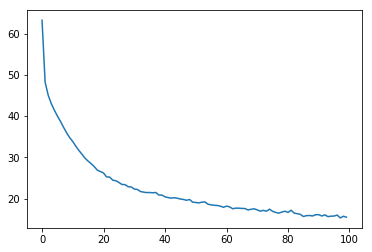

In [4]:
loss_mean_epoch = []
for epoch in range(epoch_num):
    loss_mean_epoch.append(sum(loss_epoch[epoch])/157)
plt.plot(loss_mean_epoch)

In [6]:
torch.save(model.state_dict(),'./checkpoint/temp.pth')

In [61]:
import numpy as np
import utils.train_util as train_util
model.eval()
modal_name_list=['video','audio']
tagging_class_num = 82
evl_metrics = [train_util.EvaluationMetrics(tagging_class_num, top_k=20)
                           for i in range(len(modal_name_list)+1)] #+1 for fusion
for i in range(len(evl_metrics)):
    evl_metrics[i].clear()

criterion = nn.BCELoss(reduction='none')# sum应该没问题吧
optimizer = None
loss_compute = SimpleLossCompute(criterion,optimizer)

for i,batch in enumerate(loader):
    video,audio,text,label = batch
    inputs_dict={}
    inputs_dict['video'] = video
    inputs_dict['audio'] = audio
    inputs_dict['text'] = text
    pred_dict = model(inputs_dict)
    for index,modal_name in enumerate(modal_name_list+['fusion']):
        pred = pred_dict['tagging_output_'+modal_name]
        val_label = label
        loss = loss_compute(pred['predictions'],val_label)
        pred = pred['predictions'].detach().cpu().numpy()
        val_label = label.cpu().numpy()
        #print(np.array(pred_gap))
        #print(val_label_gap)
        gap = train_util.calculate_gap(pred, val_label)
        print('gap: ',gap)
        evl_metrics[index].accumulate(pred, val_label, loss=0)
    if(i>500):
        break

gap:  0.9947396877274343
gap:  0.9824204769295231
gap:  0.9947389925049824
gap:  0.9849995300545505
gap:  0.9743947073137559
gap:  0.9849504304974611
gap:  0.9999030963690078
gap:  0.9903641571057922
gap:  0.9999239971563098
gap:  0.9950859950859898
gap:  0.9780105008492771
gap:  0.9950555862671162
gap:  0.9973495842419039
gap:  0.9890720336062035
gap:  0.9974100150560822
gap:  0.9998819309566224
gap:  0.9873112850150898
gap:  1.0000000000000042
gap:  0.9753570341275639
gap:  0.9599348685717313
gap:  0.97536325396137
gap:  0.997566909975668
gap:  0.9910614971280045
gap:  0.997566909975668
gap:  0.9973545157719649
gap:  0.9884101056732897
gap:  0.9973545157719649
gap:  1.0000000000000075
gap:  0.9866552715727663
gap:  1.0000000000000075
gap:  0.9799670391477386
gap:  0.9719914960571758
gap:  0.9800372004979281
gap:  0.9997580394223576
gap:  0.9866161166897337
gap:  0.9998618080992486
gap:  0.9999999999999989
gap:  0.9909164478691321
gap:  0.9999940944416874
gap:  0.9898121371334503
gap:

In [65]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [66]:
N_FOLDS = 3
kf = GroupKFold(n_splits = N_FOLDS)
for fold,(train_idx,val_idx) in enumerate(kf.split(df_train)):

In [77]:
kf.split(range(5000))

<generator object _BaseKFold.split at 0x7f2db0fc5308>

In [78]:
train_indices = []
val_indices = []
for fold,(train_idx,val_idx) in enumerate(kf.split(range(5000))):
    print(fold)
    train_indices.append(train_idx)
    val_indices.append(val_idx)
    

ValueError: The 'groups' parameter should not be None.

In [75]:
from torch.utils.data import random_split

train_size = int(0.9 * len(full_dataset))
validation_size = len(full_dataset) - train_size
train_dataset, validation_dataset = random_split(full_dataset, [train_size, validation_size])

#full_loader = DataLoader(full_dataset, batch_size=4,sampler = sampler_(full_dataset), pin_memory=True) 
#train_loader = DataLoader(train_dataset, batch_size=4, sampler = sampler_(train_dataset))
#val_loader = DataLoader(validation_dataset, batch_size=1, sampler = sampler_(validation_dataset))


In [68]:
import importlib
import dataloader.dataloader
importlib.reload(dataloader.dataloader)
from dataloader.dataloader import MultimodaFeaturesDataset
full_dataset = MultimodaFeaturesDataset(config['DatasetConfig'],job='training')

In [ ]:
!./setup.sh

In [12]:
!python -W ignore main.py

initialization: Kaiming
train (0): 100%|██████████████████████████████| 141/141 [00:25<00:00,  5.57it/s]
epoch(0)(video):  0.5122225717977138
epoch(0)(fusion):  0.5163583389255177
train (2): 100%|██████████████████████████████| 141/141 [00:23<00:00,  6.00it/s]
epoch(2)(video):  0.6485075505637847
epoch(2)(fusion):  0.650922732256925
train (4): 100%|██████████████████████████████| 141/141 [00:23<00:00,  6.12it/s]
epoch(4)(video):  0.6846402185257286
epoch(4)(fusion):  0.6717679303888603
train (6): 100%|██████████████████████████████| 141/141 [00:22<00:00,  6.24it/s]
epoch(6)(video):  0.6948710702830856
epoch(6)(fusion):  0.6935592059455046
train (8): 100%|██████████████████████████████| 141/141 [00:24<00:00,  5.71it/s]
epoch(8)(video):  0.7011356291544437
epoch(8)(fusion):  0.6998639782814189
train (10): 100%|█████████████████████████████| 141/141 [00:24<00:00,  5.77it/s]
epoch(10)(video):  0.7097102736614402
epoch(10)(fusion):  0.7099776392103077
train (12): 100%|██████████████████████

In [3]:
from torch.utils import tensorboard as tensorboard
TBoard = tensorboard.SummaryWriter(log_dir='./results/log')
for i in range(10):
    TBoard.add_scalar('debug/param_number', i, 0)

In [13]:
!python -W ignore end2end_main.py

Some weights of the model checkpoint at ../pretrained/bert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
initialization: Kaiming
train (0):   6%|█▌                          | 63/1125 [07:26<2:05:28,  7.09s/it]
Traceback (most recent call last):
  File "end2en

# testing

In [ ]:
def testing_loop(model, dataset,modal_name_list,device,epoch):
    model.eval()
    tagging_class_num = 82
    evl_metrics = [train_util.EvaluationMetrics(tagging_class_num, top_k=20)
                               for i in range(len(modal_name_list)+1)] #+1 for fusion
    for i in range(len(evl_metrics)):
        evl_metrics[i].clear()
    metric_dict = {}
    gap_dict = {}
    for i in range(len(dataset)):
        video,audio,text,text_mask,label = dataset[i]
        
        video = video.to(device)
        audio = audio.to(device)
        text = text.to(device)
        text_mask = text_mask.to(device)
        label = label.to(device)
        
        inputs_dict={}
        inputs_dict['video'] = video
        inputs_dict['audio'] = audio
        inputs_dict['text'] = text
        inputs_dict['attention_mask'] = text_mask
        
        pred_dict = model(inputs_dict)
        
        pred_dict['tagging_output_fusion']

In [16]:
import math
warm_up_epochs = 5
max_num_epochs = 50
warm_up_with_cosine_lr = lambda epoch: (epoch+1) / warm_up_epochs if epoch < warm_up_epochs \
    else 0.5 * ( math.cos((epoch - warm_up_epochs) /(max_num_epochs - warm_up_epochs) * math.pi) + 1)

In [17]:
lr = []
for epoch in range(35):
    lr.append(warm_up_with_cosine_lr(epoch))

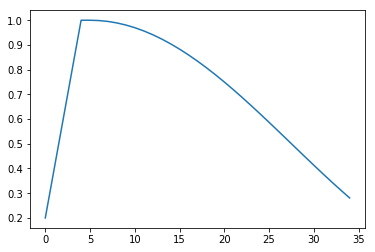

In [18]:
import matplotlib.pyplot as plt
plt.plot(lr)
plt.show()

In [5]:
!python inference.py

inference.py:18: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(open(config_path))
Some weights of the model checkpoint at ../pretrained/bert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceC